In [1]:
import os
import re
import random
import shutil
import numpy as np
import time
import jieba

In [2]:
data_dir = "../data"
stopword_file = os.path.join(data_dir, "stop_word.txt")
out_dir = "../para_data"
out_para_file = "../para_data.txt"

text_fileL = [
    "鹿鼎记",
    "天龙八部",
    "笑傲江湖",
    "倚天屠龙记",
    "神雕侠侣",
]

%matplotlib inline

In [3]:
re_preprocess = \
    re.compile(
        '[a-zA-Z0-9’"#$%&\'()*+,-./:：;<=>?@?★、…【】《》？“”‘’！[\\]^_`{|}~]+'
        )

In [4]:
# 预处理函数，将原始文本处理为断句断好的列表
def getCorpus(text_raw):
    text_raw = re_preprocess.sub("",text_raw)
    # blank space
    punctuationL =["\t","\n","\u3000","\u0020","\u00A0"," "]
    for i in punctuationL:
        text_raw = text_raw.replace(i,"")
    text_raw = text_raw.replace("，","。")
    corpus = text_raw.split("。")
    return corpus

In [5]:
if os.path.exists(out_dir):
    shutil.rmtree(out_dir)
if os.path.exists(out_para_file):
    os.remove(out_para_file)
if not os.path.exists(out_dir):
    os.mkdir(out_dir)

# 对每本小说进行处理
for text_file in text_fileL:
# text_file = text_fileL[0]
    with open(f"{data_dir}/{text_file}.txt","r",encoding="GB18030") as fp:
        text_raw = "".join(fp.readlines())
    corpus = getCorpus(text_raw)

    paraL = []
    para_len = 0
    file_id = 0
    
    # 对每个断句的部分进行处理
    for corpu in corpus:
        paraL.append(corpu)
        # 语料长度
        para_len += len(corpu)
        if para_len > 2000:
            para_len = 0
            with open(f"{out_dir}/{text_file}-{file_id:03d}.txt","w",encoding="utf-8") as fp:
                fp.writelines(paraL)
            paraL = []
            file_id += 1
    
    random_paramL = [i for i in range(file_id)]
    random.shuffle(random_paramL)
    random_paramL_40 = random_paramL[:40]
    random_paramL_40.sort()
    random_paramL_40 = [f"{out_dir}/{text_file}-{i:03d}.txt\n" for i in random_paramL_40]
    # save files' name
    with open(out_para_file,"a",encoding="utf-8") as fp:
        fp.writelines(random_paramL_40)

In [6]:
alpha = 5
beta = 0.1
epoch_num = 100


num_topic = 10  # 主题数量
start_time = time.time()


with open(stopword_file, 'r', encoding='utf-8') as fp:
    stopWordL = fp.readlines()
stopWordL = [i.strip() for i in stopWordL]

class LDA:
    def __init__(self) -> None:
        self.docs = None
        self.word2id_dict = None
        self.id2word_dict = None
        
        self.num_doc = 0
        self.num_word = 0
        self.Z = []

        # 在param_init里面初始化参数
        self.ndz = None
        self.nzw = None
        self.nz = None
        self.theta = None
        self.phi = None


    def gen_dict(self,documentL):
        word2id_dict = {}
        id2word_dict = {}
        docs = []
        cnt_document = []
        cnt_word_id = 0

        for document in documentL:
            segList = jieba.cut(document)
            for word in segList:
                word = word.strip()
                if len(word) > 1 and word not in stopWordL:
                    if word in word2id_dict:
                        cnt_document.append(word2id_dict[word])
                    else:
                        cnt_document.append(cnt_word_id)
                        word2id_dict[word] = cnt_word_id
                        id2word_dict[cnt_word_id] = word
                        cnt_word_id += 1
            docs.append(cnt_document)
            cnt_document = []
        self.docs, self.word2id_dict, self.id2word_dict = docs, word2id_dict, id2word_dict
        self.num_doc = len(self.docs)
        self.num_word = len(self.word2id_dict)


    # 随机初始化参数
    def param_init(self):
        # 各文档的词在各主题上的分布数目
        self.ndz = np.zeros([self.num_doc,num_topic]) + alpha  
        # 词在主题上的分布数
        self.nzw = np.zeros([num_topic,self.num_word]) + beta  
        # 每个主题的总词数
        self.nz = np.zeros([num_topic]) + self.num_word*beta  
        self.theta = np.zeros([self.num_doc,num_topic])
        self.phi = np.zeros([num_topic,self.num_word])

        
        for d, doc in enumerate(self.docs):
            zCurrentDoc = []
            for w in doc:
                self.pz = np.divide(np.multiply(self.ndz[d, :], self.nzw[:, w]), self.nz)
                z = np.random.multinomial(1, self.pz / self.pz.sum()).argmax()
                zCurrentDoc.append(z)
                self.ndz[d, z] += 1
                self.nzw[z, w] += 1
                self.nz[z] += 1
            self.Z.append(zCurrentDoc)


    # gibbs采样
    def gibbs_sampling_update(self):
        # 为每个文档中的每个单词重新采样topic
        for d, doc in enumerate(self.docs):
            for index, w in enumerate(doc):
                z = self.Z[d][index]
                # 将当前文档当前单词原topic相关计数减去1
                self.ndz[d,z] -= 1
                self.nzw[z,w] -= 1
                self.nz[z] -= 1
                # 重新计算当前文档当前单词属于每个topic的概率
                self.pz = np.divide(np.multiply(self.ndz[d,:], self.nzw[:,w]), self.nz)
                # 按照计算出的分布进行采样
                z = np.random.multinomial(1, self.pz / self.pz.sum()).argmax()
                self.Z[d][index] = z
                # 将当前文档当前单词新采样的topic相关计数加上1
                self.ndz[d, z] += 1
                self.nzw[z, w] += 1
                self.nz[z] += 1

        self.theta = [(self.ndz[i]+alpha)/(len(self.docs[i])+num_topic*alpha) for i in range(self.num_doc)]
        self.phi = [(self.nzw[i]+beta)/(self.nz[i]+self.num_word*beta) for i in range(num_topic)]

        


    def cal_perplexity(self):
        nd = np.sum(self.ndz, 1)
        n = 0
        ll = 0.0
        for d, doc in enumerate(self.docs):
            for w in doc:
                ll = ll + np.log(((self.nzw[:, w] / self.nz) * (self.ndz[d, :] / nd[d])).sum())
                n = n + 1
        return np.exp(ll / (-n))
    
    def show_topwords(self,num=10):
        for z in range(num_topic):
            ids = self.nzw[z, :].argsort()
            topicword = []
            for j in ids:
                topicword.insert(0, self.id2word_dict[j])
            # topicwords.append(topicword[:min(num, len(topicword))])
            print(topicword[:min(num, len(topicword))])

    
    def save_param(self,postfix):
        np.savetxt(os.path.join(out_dir,f"theta_{postfix:03d}.csv"), self.theta,fmt="%.9f",delimiter=',')
        np.savetxt(os.path.join(out_dir,f"phi_{postfix:03d}.csv"), self.phi,fmt="%.9f",delimiter=',')
        
    

In [7]:
hw_lda = LDA()

documentL = []
with open(out_para_file,"r",encoding="utf-8") as fp:
    fileL = fp.readlines()
for file in fileL:
    with open(file.strip(), 'r', encoding='utf-8') as f:
        documentL.append(f.read())

hw_lda.gen_dict(documentL)
print("gen_dict done")

hw_lda.param_init()

perplexityL = []
for i in range(epoch_num):
    hw_lda.gibbs_sampling_update()
    perplexity = hw_lda.cal_perplexity()
    perplexityL.append(perplexity)
    print(f"[{time.time()-start_time:.2f}] epoch_num={i} perplexity={perplexity:.4f}")
    if not i%10:
        hw_lda.save_param(i)


np.savetxt(os.path.join(out_dir, "perplexity.csv"), perplexityL,fmt="%.9f",delimiter=',')

hw_lda.show_topwords()

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 1.107 seconds.
Prefix dict has been built successfully.


gen_dict done
[12.75] epoch_num=0 perplexity=9156.7886
[17.17] epoch_num=1 perplexity=8974.6419
[21.39] epoch_num=2 perplexity=8796.9847
[25.59] epoch_num=3 perplexity=8609.5398
[29.87] epoch_num=4 perplexity=8420.8829
[34.28] epoch_num=5 perplexity=8230.8092
[38.58] epoch_num=6 perplexity=8065.5013
[42.81] epoch_num=7 perplexity=7943.4804
[47.03] epoch_num=8 perplexity=7785.5752
[51.26] epoch_num=9 perplexity=7653.4873
[55.55] epoch_num=10 perplexity=7516.3050
[59.99] epoch_num=11 perplexity=7405.6303
[64.25] epoch_num=12 perplexity=7297.9910
[68.94] epoch_num=13 perplexity=7192.4538
[73.24] epoch_num=14 perplexity=7095.5734
[77.37] epoch_num=15 perplexity=7000.9383
[81.75] epoch_num=16 perplexity=6914.5675
[86.02] epoch_num=17 perplexity=6837.1602
[90.31] epoch_num=18 perplexity=6790.1661
[94.56] epoch_num=19 perplexity=6740.1384
[98.78] epoch_num=20 perplexity=6687.0777
[103.04] epoch_num=21 perplexity=6650.7597
[107.24] epoch_num=22 perplexity=6597.9356
[111.52] epoch_num=23 perple

In [8]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier

from sklearn import metrics
import numpy as np



data_np = np.loadtxt(os.path.join(out_dir,"theta_090.csv"),delimiter=",")

# print(data_np.shape)
label = []
for i in range(5):
    label = label + [i]*40

X_train, X_test, y_train, y_test = train_test_split(data_np, label, test_size=.2, random_state=10)
# 训练模型
model = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True))

clt = model.fit(X_train, y_train)


y_test_pred = clt.predict(X_test)
ov_acc = metrics.accuracy_score(y_test_pred, y_test)
print(f"overall accuracy:{ov_acc:.4f}")

acc_for_each_class = metrics.precision_score(y_test, y_test_pred, average=None)
print(f"acc_for_each_class:\n")
print("{} {} {} {} {} {}".format(*acc_for_each_class,ov_acc))




overall accuracy:0.8250
acc_for_each_class:

1.0 0.625 0.8571428571428571 1.0 1.0 0.825


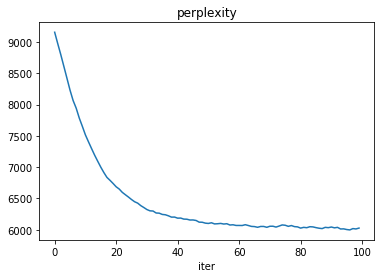

In [10]:
from cProfile import label
import matplotlib.pyplot as plt
import numpy as np



data = np.loadtxt(os.path.join(out_dir,"perplexity.csv"),delimiter=",")

plt.plot(data,label="perplexity")
plt.xlabel("iter")
plt.title("perplexity")
plt.show()

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 